# STK10 and SLK data curation

**STK10** is involved in multiple signaling pathways, including the p38 mitogen-activated protein kinase (MAPK) pathway. 
research on STK10 as a therapeutic target was still in its early stages. Preclinical studies in cell lines and animal models might have been conducted to investigate the effects of STK10 inhibition on tumor growth and other cellular processes

**SLK (STE20-like kinase)** and **STK10 (serine/threonine kinase 10, also known as LOK)** are serine/threonine kinases whose major known function is activating the ERM (ezrin/radixin/moesin) proteins by phosphorylation on a conserved threonine residue near the C-terminus (moesin Thr558). 

**Published EGFR datasets**: 
- **PKIS2**: A second chemogenomics set of kinase inhibitors from GSK, Takeda, and Pfizer was assembled as PKIS2. This set contained 645 inhibitors and included many additional chemotypes that were not represented in the original set. [ref]

**Description of readout:**
- **Readouts**: `LOK`, `SLK`
- **Bioassay readout**: Percentage of inhibition.
- **Optimization objective**: Higher the more potent.

<a id="curation"></a>
# LOK and SLK data curation

**Data pre-processing**

**Step 1** - Curate the chemistry information
  - Clean the molecules by perform molecule sanitization and fix, standardization molecules, salts/solvents removals.
  - Detect the stereochemistry information in the molecules. Such as undefined stereo centers and information. It's crucial in the case of the activity cliff among the stereoisomers.

<br>

**Step 2** - Curate the measured values
  - Identify the compounds which have multiple measures in the dataset. The identification of the repeated molecules is defined by `datamol.hash_mol` including stereochemistry information.
  - Verify the data resource and remove the dubious data points which are significant different or in different classes in case of categorical data. Compute the average of the rest of the duplicated molecules.
  - Detect potential outliers of the dataset. Verify the data resource and remove the dubious data points.
  - Convert the continuous values based on provided threshold values to classification tasks.
  - Detect activity cliff between the stereoisomers. Those isomers and their bioactivity values can be removed/masked from dataset if the downstream molecule representation is not able to differentiate the stereoisomers.

<br>

**Step 3** - Visual inspection
  - Access molecular diversity and distribution in the chemical space. This can guide the decision on which splitting approach to employ. 
  - Visualize the distribution of bioactivity values. It's useful to exam whether it's meaningful to convert to classification task.
  - Check molecules which contain undisered characters.

In [1]:
%load_ext autoreload
%autoreload 2
import datamol as dm
import pandas as pd
import polaris
from polaris import curation
import numpy as np
import umap
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os import path
from os.path import dirname
os.chdir(path.dirname(path.dirname(path.abspath("__file__"))))

/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/d

In [2]:
# load data
data = pd.read_parquet(
    "gs://polaris-private/Datasets/Kinases/pkis2_curated_&_splits_2023-08-23.parquet"
)
data.shape

(640, 2045)

In [3]:
# Define data column names
data_cols = ["LOK", "SLK"]
mol_col = "smiles"
data = data[[mol_col] + data_cols][data[data_cols].notna().any(axis=1)]

In [4]:
data.describe()[data_cols]

,LOK,SLK
count,640.000000,640.000000
mean,23.493203,25.236406
std,34.126384,29.375860
min,0.000000,0.000000
25%,0.000000,1.000000
50%,3.000000,14.000000
75%,31.250000,33.250000
max,100.000000,100.000000


In [5]:
for data_col in data_cols: 
    display(data[data_col].groupby(pd.cut(data[data_col], [0,70,75, 80, 90, 100])).count())

/var/folders/_7/ffxc1f251dbb5msn977xl4sm0000gr/T/ipykernel_93475/1691884317.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(data[data_col].groupby(pd.cut(data[data_col], [0,70,75, 80, 90, 100])).count())


LOK
(0, 70]      241
(70, 75]       9
(75, 80]       9
(80, 90]      15
(90, 100]     73
Name: LOK, dtype: int64

SLK
(0, 70]      413
(70, 75]       9
(75, 80]       9
(80, 90]      11
(90, 100]     48
Name: SLK, dtype: int64

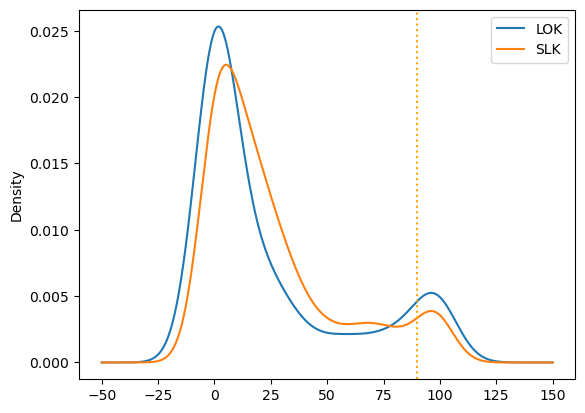

In [6]:
fig = data[data_cols].plot.kde()
plt.axvline(x=90, linestyle="dotted", color="orange")

### Perform data curation with `polaris.curation` module

In [7]:
# Define the threshold for classification conversion 
# we use the recommanded threshold 90% from the paper
th = 90
class_thresholds = {col: {"thresholds": [th]} for col in data_cols}

In [8]:
# curate
curator_with_stereo = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=True,
    class_thresholds=class_thresholds
)
df_full = curator_with_stereo()

/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mol_with_cliff), f"{data_col}_stereo_cliff"] = True
/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mol_with_cliff), f"{data_col}_stereo_cliff"] = True


In [9]:
for col in data_cols:
    print(col)
    display(df_full.query(f'`OUTLIER_{col}` == True')[data_cols])

LOK


,LOK,SLK


SLK


,LOK,SLK


### Check the compounds with undisered characters

In [10]:
from utils import basic_filter

In [11]:
processed_df = basic_filter(data = df_full, mol_col='smiles')

Filter by rules:   0%|          | 0/640 [00:00<?, ?it/s]

In [12]:
assert processed_df[processed_df.HasUndesiredEle].shape[0] == 0

There is no compounds which contains undiserable elements.

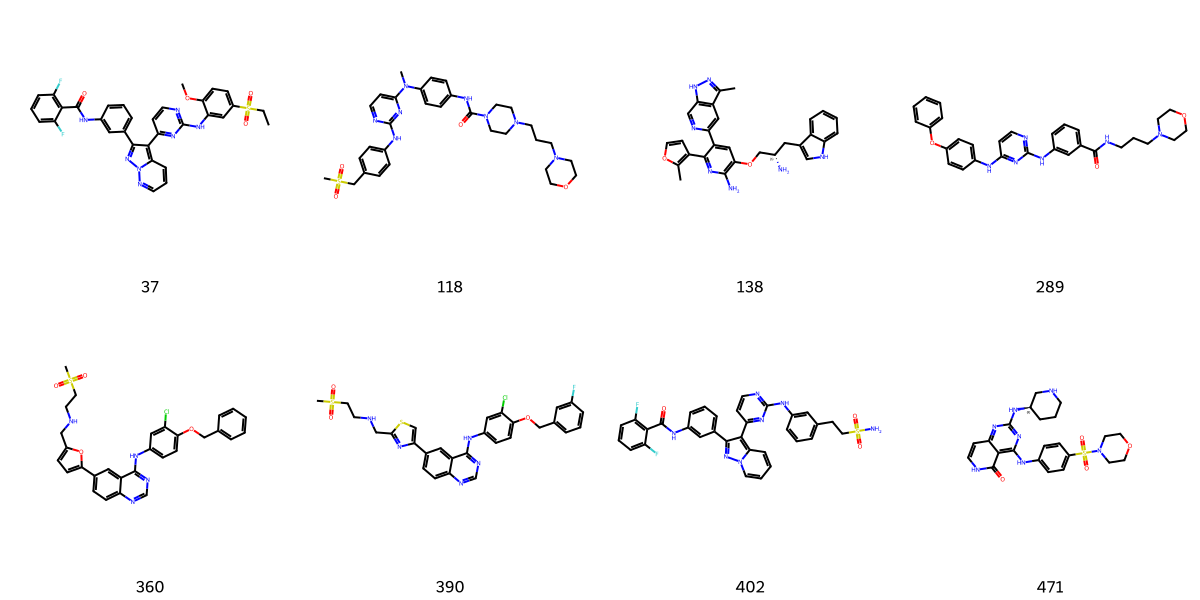

In [13]:
# visualize molecules which don't pass any of the nibr filters.
to_plot = processed_df[~processed_df.pass_any]
to_plot.reset_index(inplace=True)
legends=to_plot['index'].astype(str).tolist()
dm.to_image(to_plot['mol'].tolist(), 
            legends=legends, legendFraction=0.1,
            use_svg=True, n_cols=4)

NIBR filters are intended for molecule prioritization in the context of screening. \
Here we used to flag the molecules which are potentially undesired for the benchmark.\
From the above suggested molecules, there is no compound which contains striking unwanted substructure or extremely large groups. 

## Chemical space

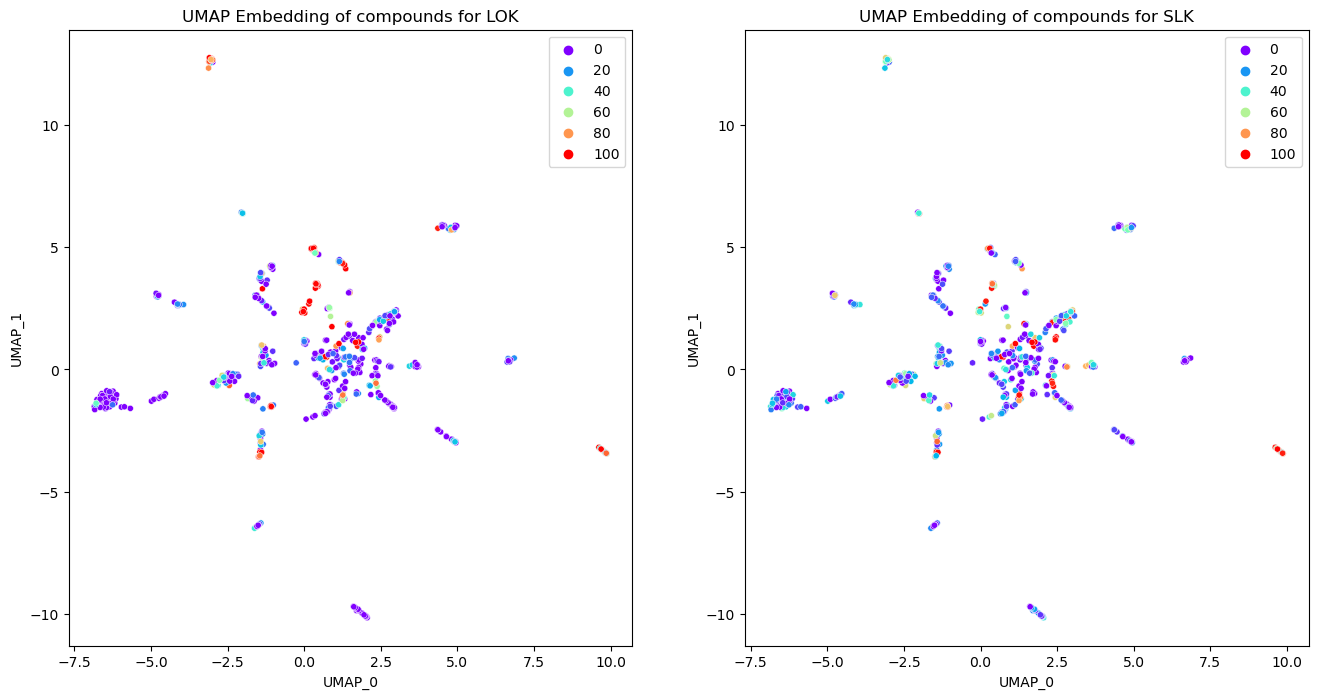

In [14]:
method = "UMAP"
mols = df_full.smiles.apply(dm.to_mol)
features = [dm.to_fp(mol) for mol in mols]
embedding = umap.UMAP().fit_transform(features)
df_full["UMAP_0"], df_full["UMAP_1"] = embedding[:, 0], embedding[:, 1]
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
axes = axes.flatten()
for i, col in enumerate(data_cols):
    sns.scatterplot(
        data=df_full,
        x="UMAP_0",
        y="UMAP_1",
        palette="rainbow",
        hue=df_full[data_cols[i]].values,
        ax=axes[i],
        s=20,
    )
    axes[i].set_title(f"{method} Embedding of compounds for {col}")

The goal are to 1) optimize the bioactivity % inhibition. 2) discovery of potential hits in new chemical space. Therefore a scaffold based split method is more relevant in this context. 

In [15]:
df_full.drop(columns=["UMAP_0", "UMAP_1"]).to_parquet( "gs://polaris-private/Data/Kinases/LOK_SLK_mutants_curated.parquet", index=False)

## Dataset creation with `Polaris`
The first step of creating a benchmark is to set up a standard dataset which allows accessing the curated dataset and all necessary information about the dataset such as data source, description of endpoints, units etc. 

In [16]:
import pandas as pd
import datamol as dm
import numpy as np
from sklearn.model_selection import ShuffleSplit

from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.benchmark import SingleTaskBenchmarkSpecification, MultiTaskBenchmarkSpecification

In [17]:
from polaris.utils.types import HubOwner
owner = HubOwner(organizationId="PolarisTest", slug="polaristest")
owner.owner

'PolarisTest'

**Create the LOK, SLK dataset with `polaris.Dataset`** 

In [18]:
# Load data
PATH = 'gs://polaris-private/Data/Kinases/LOK_SLK_mutants_curated.parquet'
table = pd.read_parquet(PATH)

Not all the columns are necessary, only the columns which are useful for the benchmarks will be annotated. Here we only use the columns that were used for training in the original paper. 

It's necessary to specify the key bioactivity columns, molecules structures and identifiers in dataset with `ColumnAnnotation`. It is possible to add `user_attributes` with any key and values when is needed, such as `unit`, `organism`, `scale` and optimization `objective`. 

**Abbrevations for the endpoint objective**
- THTB: the higher the better
- TLTB: the lower the better

In [19]:
table.rename(columns={UNIQUE_ID: "UNIQUE_ID"}, inplace=True)

In [20]:
annotations = {
     'UNIQUE_ID': ColumnAnnotation(protocol='Molecular hash ID. See <datamol.mol.hash_mol>'),
     'smiles': ColumnAnnotation(protocol='Molecule SMILES string'),
     'LOK': ColumnAnnotation(protocol='Percentage of inhibition on LOK', user_attributes={'unit': '%', 'concentration': '1uM', 'organism': 'human', 'objective': 'THTB', 'source': 'PKIS2', 'mutation': 'None', 'target': 'LOK'}),
     'SLK': ColumnAnnotation(protocol='Percentage of inhibition on SLK', user_attributes={'unit': '%', 'concentration': '1uM', 'organism': 'human', 'objective': 'THTB', 'source': 'https://pubmed.ncbi.nlm.nih.gov/26501955', 'mutation': 'None', 'target': 'SLK'}),
     'CLASS_LOK': ColumnAnnotation(protocol='Binarized label based on the percentage of inhibition on LOK', user_attributes={'thresholds': f'[{th}]', 'label_order': 'ascending', 'ref_col': 'LOK'}),
     'CLASS_SLK': ColumnAnnotation(protocol='Binarized label based on the percentage of inhibition on SLK', user_attributes={'thresholds': f'[{th}]', 'label_order': 'ascending', 'ref_col': 'SLK'})
}

**Create `Dataset` object**

In [21]:
dataset = Dataset(
    table=table[annotations.keys()],
    name="LOK_SLK",
    description=f"Profile of kinase LOK, SLK on inhibition.",
    source="https://pubmed.ncbi.nlm.nih.gov/26501955",
    annotations=annotations,
    owner=owner, 
    tags=["Kinase"]
)

In [22]:
# save the dataset
SAVE_DIR = "gs://polaris-private/Datasets/Kinases/LOK_SLK_mutants"
dataset.to_json(SAVE_DIR)

'gs://polaris-private/Datasets/Kinases/LOK_SLK_mutants/dataset.json'

In [23]:
fs = dm.fs.get_mapper(SAVE_DIR).fs
fs.ls(SAVE_DIR)

['polaris-private/Datasets/Kinases/LOK_SLK_mutants/dataset.json',
 'polaris-private/Datasets/Kinases/LOK_SLK_mutants/table.parquet']

## Benchmark creation with `Polaris`
Creating a benchmark involves setting up a standard dataset, designing the train-validation-test set and defining evaluation metrics which is used to establish baseline performance level. 

**Load existing Dataset object**

In [24]:
dataset = polaris.load_dataset("gs://polaris-private/Datasets/Kinases/LOK_SLK_mutants/dataset.json")

In [25]:
# Visualize all information about the dataset
dataset

{
  "name": "LOK_SLK",
  "description": "Profile of kinase LOK, SLK on inhibition.",
  "tags": [
    "Kinase"
  ],
  "user_attributes": {},
  "owner": {
    "slug": "polaristest",
    "organization_id": "PolarisTest",
    "user_id": null,
    "owner": "PolarisTest"
  },
  "md5sum": "be7e72808a8019806c2f53070213028a",
  "readme": "",
  "annotations": {
    "UNIQUE_ID": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": null,
      "user_attributes": {}
    },
    "smiles": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": null,
      "user_attributes": {}
    },
    "LOK": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": null,
      "user_attributes": {
        "unit": "%",
        "concentration": "1uM",
        "organism": "human",
        "objective": "THTB",
        "source": "PKIS2",
        "mutation": "None",
        "target": "LOK"
      }
    },
    "SLK": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": null,
      "user_attributes": {
        "unit": "%",
        "concentration": "1uM",
        "organism": "human",
        "objective": "THTB",
        "source": "https://pubmed.ncbi.nlm.nih.gov/26501955",
        "mutation": "None",
        "target": "SLK"
      }
    },
    "CLASS_LOK": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": null,
      "user_attributes": {
        "thresholds": "[90]",
        "label_order": "ascending",
        "ref_col": "LOK"
      }
    },
    "CLASS_SLK": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": null,
      "user_attributes": {
        "thresholds": "[90]",
        "label_order": "ascending",
        "ref_col": "SLK"
      }
    }
  },
  "source": "https://pubmed.ncbi.nlm.nih.gov/26501955",
  "license": null,
  "cache_dir": "/Users/lu.zhu/Library/Caches/polaris/datasets/LOK_SLK/be7e72808a8019806c2f53070213028a"
}

## Create scaffold split for LOK, SLK

In [26]:
# scaffold split
from partitio._scaffold_split import ScaffoldSplit
flag = True
TEST_SIZE = 0.2
while flag:
    nums_pos_test = []
    SEED = np.random.randint(1,1000,1)[0]
    SEED = 128
    splitter = ScaffoldSplit(smiles=dataset.table.smiles.values, n_jobs=-1, test_size=TEST_SIZE, random_state=SEED)
    scaffold_split = next(splitter.split(X=dataset.table.smiles.values))
    for data_col in data_cols:
        num_pos_test = dataset.table.loc[scaffold_split[1], f"CLASS_{data_col}"].sum()
        nums_pos_test.append(num_pos_test)
    flag = min(nums_pos_test) < 10


In [27]:
print(SEED, nums_pos_test)

128 [17.0, 12.0]


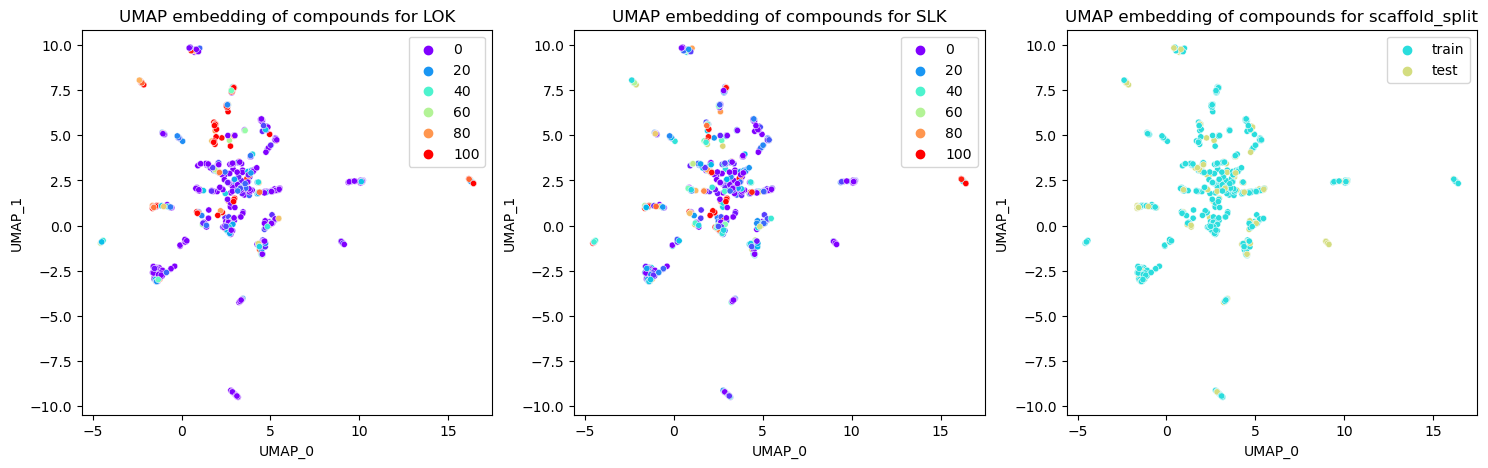

In [28]:
from utils import display_umap
fig = display_umap(df_full, 'smiles', split =scaffold_split, split_name="scaffold_split", data_cols=data_cols)

## Multitask for LOK, SLK with scaffold split 

**Regression**

In [29]:
data_cols = ['LOK', 'SLK']
name ="LOK_SLK_multitask_reg"
BENCHMARK_DIR = f"gs://polaris-private/benchmarks/Kinases/{name}"

benchmark_reg = MultiTaskBenchmarkSpecification(
    name=name,
    dataset=dataset,
    target_cols=data_cols,
    input_cols="smiles",
    split=scaffold_split,
    metrics="mean_squared_error",
    tags = ['Kinase', 'HitDiscovery',"regression"],
    description="Multitask regression benchmark for LOK and SLK wild type.",
    owner=owner,
)
path = benchmark_reg.to_json(BENCHMARK_DIR)
print(path)

gs://polaris-private/benchmarks/Kinases/LOK_SLK_multitask_reg/benchmark.json


**Classification**

In [30]:
data_cols = ['CLASS_LOK', 'CLASS_SLK']
name ="LOK_SLK_multitask_clf"
BENCHMARK_DIR = f"gs://polaris-private/benchmarks/Kinases/{name}"

benchmark_clf = MultiTaskBenchmarkSpecification(
    name=name,
    dataset=dataset,
    target_cols=data_cols,
    input_cols="smiles",
    split=scaffold_split,
    metrics="accuracy",
    tags = ['Kinase', 'HitDiscovery', 'Classification'],
    description="Multitask classification benchmark for LOK and SLK wild type.",
    owner=owner
)
path = benchmark_clf.to_json(BENCHMARK_DIR)
print(path)

gs://polaris-private/benchmarks/Kinases/LOK_SLK_multitask_clf/benchmark.json
